# Figure 3

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Scientific and datavis stack
import iris
import matplotlib.pyplot as plt

In [3]:
# My packages
from aeolus.calc import d_dz, spatial_mean, vertical_mean, water_path
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.coord import get_cube_rel_days
from aeolus.core import AtmoSim
from aeolus.io import load_data
from aeolus.meta import update_metadata
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator, tex2cf_units
from aeolus.subset import l_range_constr
from pouch.clim_diag import (
    amplitude_of_wave_crest,
    bv_freq_sq,
    calc_derived_cubes,
    longitude_of_wave_crest,
)
from pouch.plot import KW_MAIN_TTL, KW_SBPLT_LABEL, KW_ZERO_LINE, figsave, use_style

In [4]:
# Local modules
import mypaths
from angular_momentum_budget import AngularMomentumBudget
from commons import GLM_SUITE_ID, SIM_LABELS, DAYSIDE, troposphere

Apply custom matplotlib style sheet.

In [5]:
use_style()

## Load the data for the two key experiments

Define paths to input data and results.

In [6]:
img_prefix = f"{GLM_SUITE_ID}_spinup"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_spinup"
time_prof = "mean_days0_499"
plotdir = mypaths.plotdir / img_prefix

Load processed data.

In [7]:
# Load processed data
runs = {}
for sim_label, sim_prop in SIM_LABELS.items():
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )

    add_planet_conf_to_cubes(cl, const)
    # Derive additional fields
    calc_derived_cubes(cl, const=const, model=um)
    # Use the cube list to initialise an AtmoSim object
    runs[sim_label] = AngularMomentumBudget(
        cl,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
        vert_coord="z",
    )

Define a new function to calculate the Eady Growth rate.

In [8]:
@update_metadata(name="eady_growth_rate", units="day-1")
def eady_growth_rate(atm_sim):
    """
    Calculate Eady Growth Rate following Vallis (2017).
    
    .. math::
        \sigma_E = 0.31|f|\frac{|\partial u/\partial z|}{N},
    where :math:`f` is the Coriolis parameter, :math:`u` is the zonal wind, :math:`z` is height,
    and :math:`N` is the Brunt-Vaisala frequency.
    
    Parameters
    ----------
    atm_sim: aeolus.core.AtmoSim
        AtmoSim-type object containing `coriolis` and other relevant variables.

    References
    ----------
    Vallis (2017)
    """
    factor = 0.31
    fcor = atm_sim.coriolis
    fcor_abs = fcor.copy(data=abs(fcor.core_data()))
    bv_freq = bv_freq_sq(atm_sim._cubes) ** 0.5
    bv_freq_vm = vertical_mean(
        bv_freq,
        weight_by=atm_sim.dens,
    )
    du_dz = vertical_mean(d_dz(atm_sim.u), weight_by=atm_sim.dens)
    return factor * fcor_abs * du_dz / bv_freq_vm

Define the time period to focus on.

In [9]:
day_start = 0
day_end = 200
day_constr = iris.Constraint(
    **{um.fcst_prd: lambda x: day_start <= x.point / 24 <= day_end}
)
tm_suffix = f"day{day_start:03d}-{day_end:03d}_mean"

In [10]:
DIAGS = {
    "wvp_d": {
        "recipe": lambda AS: spatial_mean(
            water_path(AS._cubes.extract(DAYSIDE.constraint))  # SS_PM15
        ),
        "title": "Water vapour path",
        "tex_units": "$kg$ $m^{-2}$",
        "lim": [0, 60],
        "fmt": lambda x: f"{x:.1f}",
    },
    "dt_rad_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                sum(
                    [
                        AS[i].extract(troposphere & DAYSIDE.constraint)
                        for i in ["dt_sw", "dt_lw"]
                    ]
                ),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean SW+LW heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_sw_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_sw.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean SW heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_sw_cs_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_sw_cs.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean SW CS heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_lw_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_lw.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean LW heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_lw_cs_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_lw_cs.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean LW CS heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_diab_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                sum(
                    [
                        AS[i].extract(troposphere & DAYSIDE.constraint)
                        for i in ["dt_sw", "dt_lw", "dt_bl", "dt_lsppn", "dt_cv"]
                    ]
                ),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "lim": [-0.8, 1.4],
        "title": "Day-side mean diabatic heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_lh_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                sum(
                    [
                        AS[i].extract(troposphere & DAYSIDE.constraint)
                        for i in ["dt_bl", "dt_lsppn", "dt_cv"]
                    ]
                ),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "lim": [-0.8, 1.4],
        "title": "Day-side mean latent heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_bl_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_bl.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean BL heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_lsppn_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_lsppn.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "title": "Day-side mean LSPPN heating",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "dt_cv_d": {
        "recipe": lambda AS: spatial_mean(
            vertical_mean(
                AS.dt_cv.extract(troposphere & DAYSIDE.constraint),
                weight_by=AS.dens.extract(troposphere & DAYSIDE.constraint),
            )
        ),
        "lim": [-0.2, 0.65],
        "title": "Day-side mean heating due to convection",
        "tex_units": "$K$ $day^{-1}$",
        "fmt": "3.1f",
    },
    "eady_growth": {
        "recipe": lambda AS: spatial_mean(
            eady_growth_rate(
                AS.extract(
                    iris.Constraint(**{um.y: lambda x: 30 <= abs(x.point) <= 80})
                    & l_range_constr(1.5, 6.0)
                ),
            )
        ),
        "title": "Eady growth rate",
        "short_title": r"$\sigma_E=0.31f\frac{du/dz}{N}$",
        "tex_units": "$day^{-1}$",
        "fmt": "3.2f",
    },
}

Choose the variables to plot.

In [11]:
vrbls_to_show = ["wvp_d", "dt_sw_d", "dt_lw_d", "dt_cv_d", "dt_diab_d", "eady_growth"]

Do the calculations for each of the diagnostics and store results in a separate dictionary.

In [12]:
RESULTS = {}
caught_errors = []
for vrbl_key in vrbls_to_show:
    vrbl_prop = DIAGS[vrbl_key]
    RESULTS[vrbl_key] = {}
    for sim_label in SIM_LABELS.keys():
        # if vrbl_prop.get("source", "") == "p":
        #     the_run = runs_p[sim_label].extract(day_constr)
        # else:
        the_run = runs[sim_label].extract(day_constr)

        # Calculate diagnostics
        cube = vrbl_prop["recipe"](the_run)
        try:
            cube.convert_units(tex2cf_units(vrbl_prop["tex_units"]))
        except ValueError as e:
            caught_errors.append(f"{vrbl_key}: {e}")
        RESULTS[vrbl_key][sim_label] = cube
if caught_errors:
    print(caught_errors)

## Create a figure

In [13]:
nrows = len(vrbls_to_show)
ncols = 1

fig = plt.figure(figsize=(ncols * 16, nrows * 3.5))
axd = fig.subplot_mosaic(
    [[vrbl_key] for vrbl_key in vrbls_to_show], gridspec_kw={"hspace": 0.3}
)  # show bottom first

if len(axd) > 1:
    iletters = subplot_label_generator()
    for ax in axd.values():
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
for vrbl_key in vrbls_to_show:
    vrbl_prop = DIAGS[vrbl_key]
    ax = axd[vrbl_key]
    ttl = vrbl_prop["title"]
    if short_ttl := vrbl_prop.get("short_title"):
        # ttl += f" ({short_ttl})"
        # ax.set_title(short_ttl, **KW_AUX_TTL)
        pass
    ax.set_title(ttl, **KW_MAIN_TTL)
    # ax.add_artist(AnchoredText(ttl, loc=""))
    ax.set_xlim(day_start, day_end)
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Time [days]")
    if (tex_units := vrbl_prop["tex_units"]) not in ["1", None]:
        ax.set_ylabel(f"[{tex_units}]")
    if lim := vrbl_prop.get("lim"):
        ax.set_ylim(lim)
        if min(lim) < 0 and max(lim) > 0:
            ax.axhline(0, **KW_ZERO_LINE)

    for sim_label, sim_prop in SIM_LABELS.items():
        cube = RESULTS[vrbl_key][sim_label]
        ax.plot(get_cube_rel_days(cube), cube.data, **sim_prop["kw_plt"])
add_custom_legend(
    fig,
    {sim_prop["title"]: sim_prop["kw_plt"] for sim_prop in SIM_LABELS.values()},
    loc="upper center",
    bbox_to_anchor=(0.5, 1.0 - 0.065),
    frameon=False,
    ncol=min(3, len(SIM_LABELS)),
    title=f"Time series of the first {day_end} days of simulations",
)
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS)}__tseries__{'_'.join(vrbls_to_show)}__{tm_suffix}"
plt.close()

# Show the figure

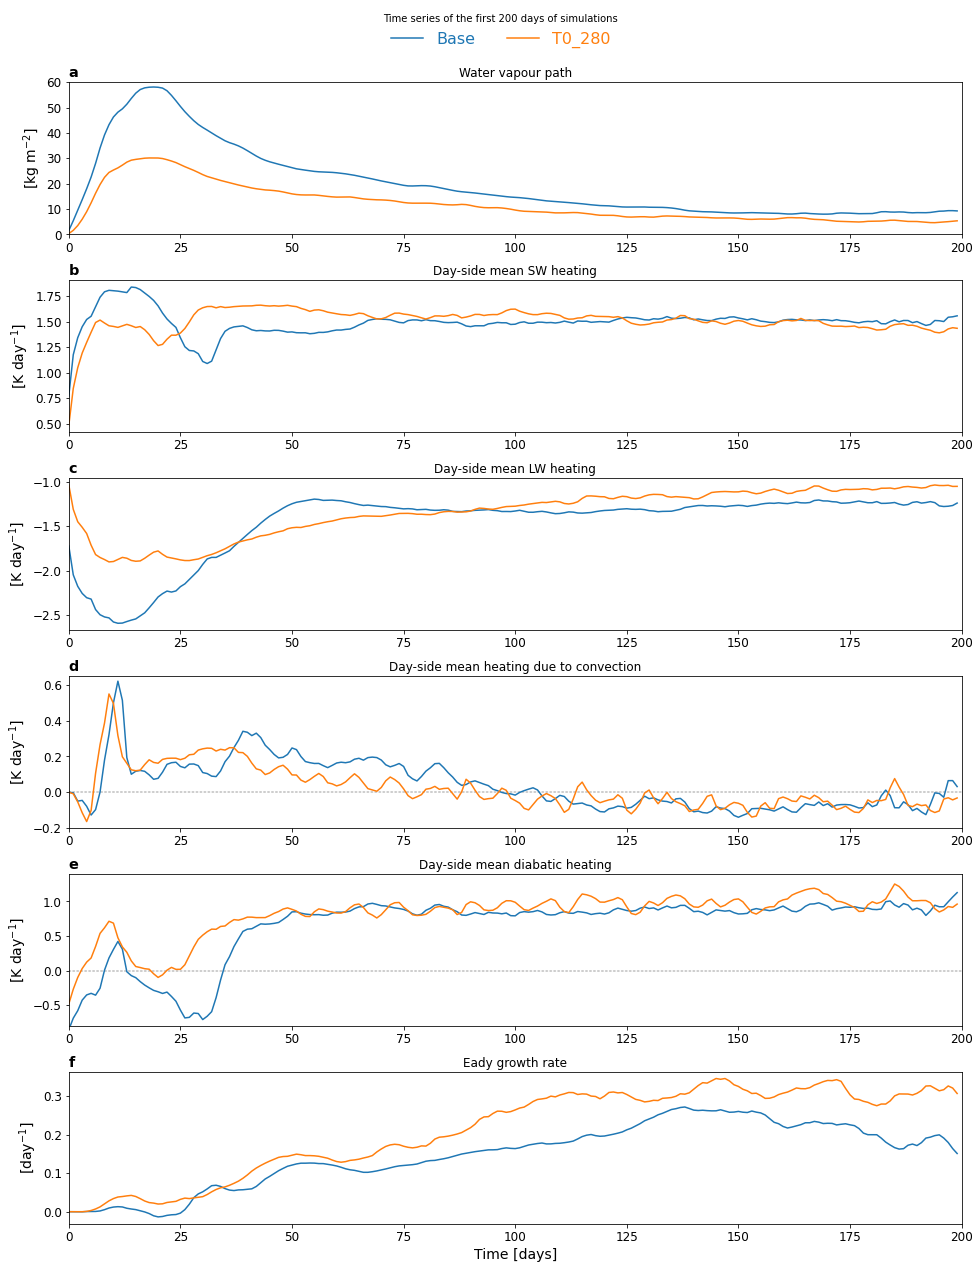

In [14]:
fig

Spin-up diagnostics for the first 200 days of the (blue lines) _Base_ and (orange lines) _T0\_280_ simulations: (a) water vapor path, (b) shortwave radiative heating rate, (c) longwave radiative heating rate, (d) convective heating rate, (e) diabatic (radiative plus latent) heating rate, (f) the Eady growth rate.

The water vapor path is averaged over the day side, integrated vertically and has units of $kg\,m^{-2}$.
The heating rates are averaged spatially over the day side and vertically over the troposphere and have units of $K\,day^{-1}$.
The Eady growth rate is averaged within $850-500\,hPa$ in mid-latitudes $30-80^{\circ}$ and has units of $day^{-1}$.

And save it.

In [15]:
figsave(fig, plotdir / imgname)

Saved to ../plots/ch111_spinup/ch111_spinup__base_sens-t280k__tseries__wvp_d_dt_sw_d_dt_lw_d_dt_cv_d_dt_diab_d_eady_growth__day000-200_mean.png
